# Exercise 3
# Q1

We consider the discrete-time LTI system  
$$
x_{n+1}=Ax_n+Bu_n,\quad n=0,\dots,N-1,\qquad x_0=\begin{bmatrix}0\\0\\0\\0\\0\\0\end{bmatrix}\in\mathbb{R}^6
$$
and the objective  
$$
\min_{\{x_n,u_n\}} \;\; \frac{1}{2}\sum_{n=0}^{N}\Big((x_n-x_d)^\top Q(x_n-x_d) \;+\;  u_n^\top R u_n\Big),
$$

Introduce Lagrange multipliers $\lambda_{n+1}\in\mathbb{R}^6$ for the dynamics (with $x_0$ fixed).  
The Lagrangian is
$$
\mathcal{L}=\frac{1}{2}\sum_{n=0}^{N}\Big((x_n-x_d)^\top Q(x_n-x_d) \;+\;  u_n^\top R u_n\Big)
+\sum_{n=0}^{N-1}\Big(\lambda_{n+1}^\top(Ax_n+Bu_n-x_{n+1})\Big).
$$

**KKT conditions:**

**(1) Primal feasibility**  
$$
x_{n+1}=Ax_n+Bu_n,\; n=0,\dots,N-1,\qquad x_0=\begin{bmatrix}0\\0\\0\\0\\0\\0\end{bmatrix}\in\mathbb{R}^6 .
$$

**(2) Stationarity**  
- Take the partial derivative of the Lagrangian ($\mathcal{L}$) with respect to $u_n$ $(n=0,\dots,N-1)$  
$$
\frac{\partial\mathcal{L}}{\partial u_n}=Ru_n+B^\top\lambda_{n+1}=0
\;\Rightarrow\;
\boxed{\,u_n=-R^{-1}B^\top\lambda_{n+1}\,},\; n=0,\dots,N-1.
$$
- Take the partial derivative of the Lagrangian ($\mathcal{L}$) with respect to $u_N$  
$$
\frac{\partial\mathcal{L}}{\partial u_N}=Ru_n=0
\;\Rightarrow\;
\boxed{\,u_N=0\,}.
$$
- Take the partial derivative of the Lagrangian ($\mathcal{L}$) with respect to $x_n$ $(n=0,\dots,N-1)$ 
$$
\frac{\partial\mathcal{L}}{\partial x_n}=Q(x_n-x_d)+A^\top\lambda_{n+1}-\lambda_n=0
\;\Rightarrow\;
\boxed{\,\lambda_n=Q(x_n-x_d)+A^\top\lambda_{n+1}},\; n=0,\dots,N-1.
$$
- Take the partial derivative of the Lagrangian ($\mathcal{L}$) with respect to $x_N$  
$$
\frac{\partial\mathcal{L}}{\partial x_N}=Q(x_N-x_d)-\lambda_N=0
\;\Rightarrow\;
\boxed{\,\lambda_N=Q(x_N-x_d)\,},\qquad
$$
**(3) Dual feasibility & complementary slackness**  
Only equality constraints are present, so no inequality multipliers or complementarity terms.

Arranged as follows
$$
\begin{cases}
x_{n+1}=Ax_n+Bu_n,\;\qquad n=0,\dots,N-1\\
x_0=\begin{bmatrix}0\\0\\0\\0\\0\\0\end{bmatrix},\\
u_n=-R^{-1}B^\top\lambda_{n+1},\;\qquad n=0,\dots,N-1,\\
u_N=0\qquad (Assuming \quad R \quad is \quad invertible)\\
\lambda_n=Q(x_n-x_d)+A^\top\lambda_{n+1}\;\qquad n=0,\dots,N-1,\\
\lambda_N=Q(x_N-x_d)\\
\end{cases}
$$
# Q2

In [57]:
import numpy as np
import quadrotor

# 先看形状
print("A shape:", quadrotor.A.shape)   # 期望 (6, 6)
print("B shape:", quadrotor.B.shape)   # 期望 (6, 2)
print("dt:", quadrotor.dt)

# 再把内容打印出来（可选）
np.set_printoptions(precision=3, suppress=True)
print(f"A =\n{quadrotor.A}")
print(f"B =\n{quadrotor.B}")

# 若接下来要用到 Q2/Q3/Q4：
A, B, dt = quadrotor.A.copy(), quadrotor.B.copy(), quadrotor.dt


A shape: (6, 6)
B shape: (6, 2)
dt: 0.01
A =
[[ 1.     0.01   0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.    -0.098  0.   ]
 [ 0.     0.     1.     0.01   0.     0.   ]
 [ 0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     1.     0.01 ]
 [ 0.     0.     0.     0.     0.     1.   ]]
B =
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.02   0.02 ]
 [ 0.     0.   ]
 [ 0.015 -0.015]]


In [58]:
import numpy as np

def solve_lqt_q2(A, B, Q, R, N, x0, x_des):
    """
    Finite-horizon LQT (tracking a constant setpoint x_des) via backward Riccati + forward rollout.
    Returns:
        X: (nx, N+1) state trajectory
        U: (nu, N)   control sequence
        Kbar_list: list of feedback+feedforward gains (-K e - k) packed as Kbar[n] @ [e;1]
    """
    A = np.asarray(A, float); B = np.asarray(B, float)
    Q = np.asarray(Q, float); R = np.asarray(R, float)
    x0 = np.asarray(x0, float).reshape(-1)
    x_des = np.asarray(x_des, float).reshape(-1)

    nx, nu = A.shape[0], B.shape[1]
    assert A.shape == (nx, nx)
    assert B.shape == (nx, nu)
    assert Q.shape == (nx, nx)
    assert R.shape == (nu, nu)
    assert x0.shape == (nx,)
    assert x_des.shape == (nx,)

    # Augmented dynamics for tracking e_n = x_n - x_des
    d = (A - np.eye(nx)) @ x_des                     # constant drift
    Abar = np.block([[A,                 d.reshape(-1,1)],
                 [np.zeros((1, nx)), np.array([[1.0]])]])
    Bbar = np.vstack([B, np.zeros((1, nu))])
    Qbar = np.block([[Q,                  np.zeros((nx,1))],
                 [np.zeros((1, nx)), np.array([[0.0]])]])

    # Backward Riccati
    P = [None]*(N+1)
    Kbar_list = [None]*N
    P[N] = Qbar.copy()
    for n in range(N-1, -1, -1):
        S = R + Bbar.T @ P[n+1] @ Bbar                     # (nu,nu), SPD
        # Kbar = S^{-1} Bbar^T P Abar  —— 用 solve 避免显式逆
        Kbar = np.linalg.solve(S, Bbar.T @ P[n+1] @ Abar)  # (nu, nx+1)
        P[n] = Qbar + Abar.T @ P[n+1] @ (Abar - Bbar @ Kbar)
        Kbar_list[n] = Kbar

    # Forward rollout
    X = np.zeros((nx, N+1))
    U = np.zeros((nu, N))
    z = np.zeros((nx+1, N+1))                  # z = [e; 1]
    z[:nx, 0] = x0 - x_des
    z[nx, 0] = 1.0
    for n in range(N):
        U[:, n] = - Kbar_list[n] @ z[:, n]     # u = -Kbar [e;1] = -K e - k
        z[:, n+1] = Abar @ z[:, n] + Bbar @ U[:, n]

    # Recover x = e + x_des
    X = z[:nx, :] + x_des.reshape(-1,1)
    return X, U, Kbar_list

# ---------- Q2 参数（可根据作业给定值修改） ----------
# 假定你已从老师给的代码里定义了 A, B
N = 500
x0 = np.zeros(A.shape[0])                      # 形状 (6,)
x_des = np.array([-3, 0, 3, 0, 0, 0], float)
Q = np.diag([12, 1.5, 12, 1.5, 8, 2.0])
R = 0.10 * np.eye(B.shape[1])

# 仅计算，不输出（供 Q3/Q4 直接复用）
X, U, Kbar = solve_lqt_q2(A, B, Q, R, N, x0, x_des)


# Q3

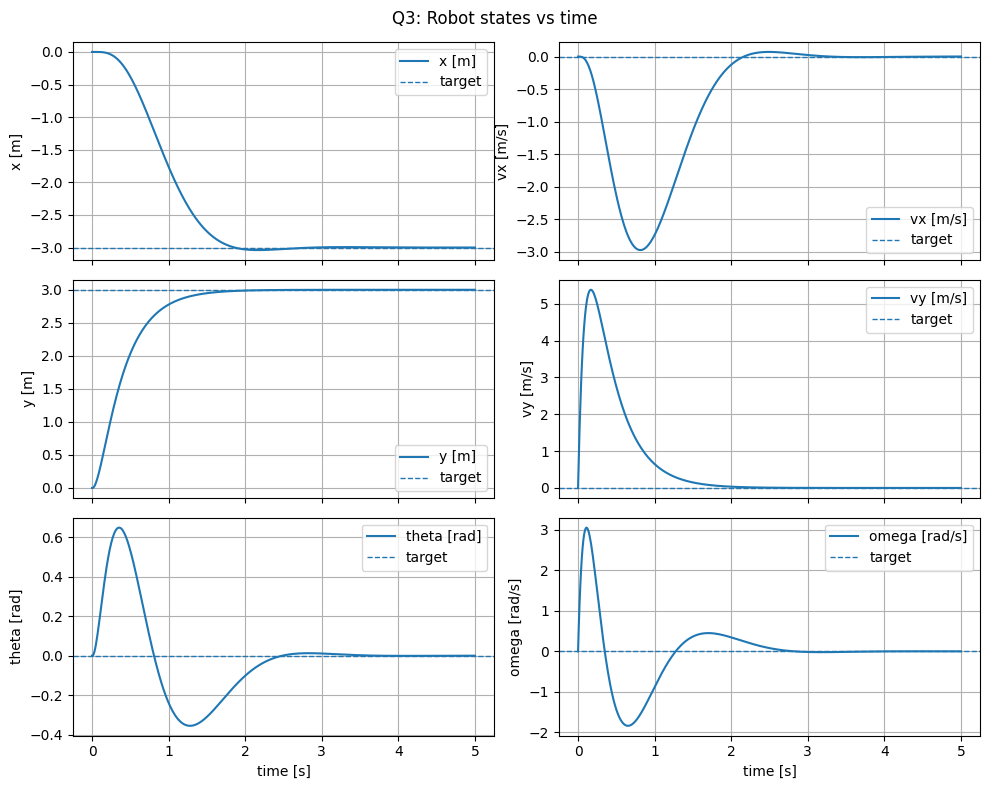

In [59]:
# === Q3: Show plots of all the states of the robot as a function of time ===
import numpy as np
import matplotlib.pyplot as plt

# 1) 获取数据：优先用内存中的 X、dt、x_des；否则从 q2_solution.npz 读取
if 'X' not in globals() or 'dt' not in globals():
    data = np.load('q2_solution.npz', allow_pickle=True)
    X = data['X']                  # shape (6, N+1)
    dt = float(data['dt'])         # e.g., 0.01
    x_des = data['x_des'].reshape(-1)
else:
    # 若 x_des 没有在内存中，也尝试读取（只是为了画参考虚线）
    if 'x_des' not in globals():
        try:
            data = np.load('q2_solution.npz', allow_pickle=True)
            x_des = data['x_des'].reshape(-1)
        except:
            x_des = None

# 2) 时间轴
t = np.arange(X.shape[1]) * dt

# 3) 画 6 个状态
state_labels = ['x [m]', 'vx [m/s]', 'y [m]', 'vy [m/s]', 'theta [rad]', 'omega [rad/s]']
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex=True)
axes = axes.ravel()

for i in range(6):
    ax = axes[i]
    ax.plot(t, X[i], label=f'{state_labels[i]}')
    # 目标状态的参考虚线（若可用）
    try:
        if x_des is not None:
            ax.axhline(x_des[i], linestyle='--', linewidth=1, label='target')
    except NameError:
        pass
    ax.set_ylabel(state_labels[i])
    ax.grid(True)
    ax.legend(loc='best')

axes[-2].set_xlabel('time [s]')
axes[-1].set_xlabel('time [s]')
fig.suptitle('Q3: Robot states vs time')
plt.tight_layout()
plt.show()


# Q4

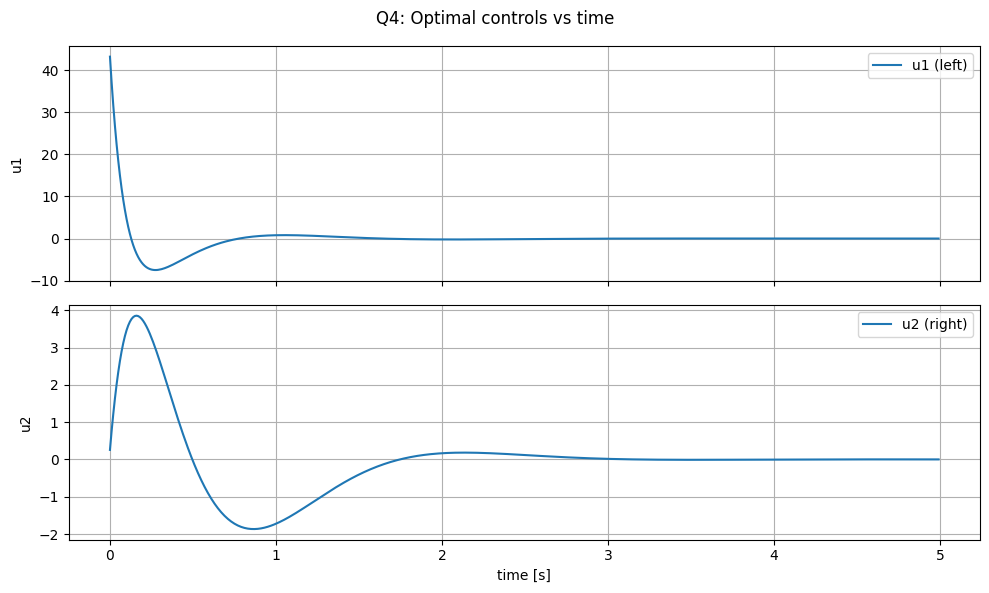

In [60]:
# === Q4: Show plots of the optimal control as a function of time ===
import numpy as np
import matplotlib.pyplot as plt

# 1) 获取控制序列与时间步长
if 'U' not in globals() or 'dt' not in globals():
    data = np.load('q2_solution.npz', allow_pickle=True)
    U = data['U']                  # shape (2, N)
    dt = float(data['dt'])         # e.g., 0.01

# 2) 时间轴（与控制长度一致）
t = np.arange(U.shape[1]) * dt

# 3) 画两路最优控制
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t, U[0], label='u1 (left)')
axes[0].set_ylabel('u1')
axes[0].grid(True); axes[0].legend(loc='best')

axes[1].plot(t, U[1], label='u2 (right)')
axes[1].set_ylabel('u2'); axes[1].set_xlabel('time [s]')
axes[1].grid(True); axes[1].legend(loc='best')

fig.suptitle('Q4: Optimal controls vs time')
plt.tight_layout()
plt.show()


In [61]:
import quadrotor

# 确保形状匹配：x0 要 (6,1)，U 要 (2,N)
x0_anim = np.zeros((6,1))
U_anim  = U                      # (2,N)，若 N 很大也可切一段：U[:, :300]

# 可用 Q2 的目标位置作为绿点
goal = [float(x_des[0]), float(x_des[2])]

quadrotor.animate_robot(x0_anim, U_anim, goal=goal)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAALh1tZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAR
nmWIhAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIG
gAnT9142XEBOWMYo5kC4iOZ7bs1+xiEBsU6V7ANEXgh8o0MwfgW/+r1EfwEKeZAK2Q6YMU7kWwcL
+CH4Q3OpCt93eWmYkUtr4w0Mpmzd8CNjbSlfoD4RcOKd6KdL/VHdtoQWxJdtt/qEhWZ5eoZxo/xV
PDEKt3Ida9oGsOPU37B1neltayvbVsPfQes0gAfcv18upjbZExfS427brWI3rfHfnfj50LeiKVEg
yF3U/ZDoyoARddDF5HfIKOckQ36Gn6p4tQmy+4rjdTwJcoh/L9OtfZN+tBsRsdDNyiKsoQiVRM10
feyLU4/dWNdrfjknxz/H8mtQnUI44CRNhCH+DQx3yhidL6+c+GWEBqCNR91VrFRhfLiXar9H/mVp
8vDEj8bBmQ2MW9XlFEUx/xNg6ZdcN6sBBPSI6dD+OQJjAEs+H5akrlfAaLovs5e7oPGeJnB7hyzD
vjmSfxrdIQC+9CO2Fv/JpIx0q2B8A6MO5/gzl+ORHwBjzb8LHBkXaPv5JBnrnnlphmwVNR0c4Tk3
uRfmYEMrYAp+kTjEaj6pTcCE7rnSmE812gQG4g0vaX4YxcGwO26FJTM+hJ4y6Qy2+KzP+luTlEib
GvgsnRQV0MTo2gjEj0plymDuA5e6cAwuHiwsGispJErK+CYQ2YwDLA7I6wNc4exQVp18V+4fu+bA
zMSt27nlRyS6VlFhOE/U8zUzsfMevhiXWYzwSO+zPDfkf4y1K8HId6mW1zMh4xPiqLzl2rq9Ej4i
yobjzvn7lnxTP51rPGeACoPLw8B0iDOR3dD7o0NV5/xHdKxJgxKZ4RUlF7kew7JVS3wVIa8PEvVq
ue/HFE57noJl1HC4bwj6JqAjelzP+R9n2ezNnUlFoC8KeVDEMLe1n8l8ypRe/Mf8XtgywTp7RmiS
Q3w/jBhsHuXtk9C9KB8DGDN8v23K8/jAWRsgCInixAAs/x6TILEvNMmyH/xhd20tTRqkKzy7NAMn
//7JlPN7FL8ha1IQV5T2N/YmvZ4/9yWzY4IQ47hLlebZD7goPvoOKZbH2vJ8/Taa8w7no4MYAAAD
AAFq12m3QcB3vL7y43El34mmSe+Rn8e1LuCHbOYY9llwWTKBvGWKzmgI5DqJddK7jrzVVO9k/OZy
+adJJHWxY+EaGlpx5HcHF4OI/D1M8jRglgyUm18knWO3Il8N+LwjRXaZXsxy7eJQ4JNBNeolOmH+
KXxsIFY1VuxAfq9TFekP7Cvv8X+dbza3MBi+Gr2kruiAd9ZfMuexBDdc2JkVlGA8njfX11ovaMCu
ShcIYsfXNF8BHjxnQWddbOIsMVE4UzroTCet7yn90tag+WnhIEEZERJg+XhEL071zJeZB4N87T96
JQeAIpamgOFpEhjSPQnSSsnPflkRz150VuAnJ3vCOgoOqYs2N656jGPBQ+Q9E4e1tDu1s/6pfMDY
eMAep20a9JPLGX/cmdLp0gyn9I9L7e9dFwVKevKUehweOXVLOsPcWCl/6DSQdQ4bttluJn26BBr9
ToGN0J0o+Da+udT48ZTxZFTy68JcXlSrC7oZyfAVBFkDhMNn0mbxlJxxlDf0+A0rkgUd2irftV0b
rRTiBW9WGGzwtElnqTNSloskt4AAAAMBGalBuPnrWllwtAAj8kC/cRD4diWCeEYAdap2N05qDqHl
/1MbjamecPNY2Y7JXnwfVbQ4OEQRyInC82Flqt13YV669/XxQGjWRFMXmR9VHmSGhTXqoBqPOBXJ
Z4sX165wUuyNiy2SlV/nryExtGLB61O1yeoF/Mu9U4yOWBfC51WsEjJYNs1252LMNynAzf/9gej0
nXzUsR8ANbTSpgwvzAa0Q2ZFnIkWg2l8tBk5QiU4L8QMauDT+qiExVJEGsLWNqKK8pEAxMn/Irsa
mtRvSkk7jdFuEtN/QetVrcifoNB0BaQq8War5iXkw696yYxtNxzhrTLn+bG/kGSLDjSv/YUcbmxB
GUqoV+iILgZr+AsO4nbo5y+vAEc/vFG0G822nu4WcEtdz+fCxJuPHjI8lcVKx6HM/dUHrBZ6APVo
W//iZVS83Wp99AAARgAkNZMTEzD2/4uIOs1GTI1eXJmr9X+4A0keYuvjJZ7XQEk1w41DQw/omLow
oLLf2TC5tlFDT8vmOsF5/DzOsjM1KrawAcTQ+zikg/RhjHTpSjbrg78+m+Iv6KgM2R4P4At2HF2W
2x0xgLxzJF54tS0RHgDXF92xAGPIbIS2S8nEb8bKy4Vdqi1hC2Yl/XZerrJON4eys9R4WeZwDFZD
74I5/nb+hFWHdeHy3T823bQaf3aTVZJGb+I07V93qSfhgMyUlLgm3zKbTDmuCyR+MUlQ1yOfNHUU
A+p9UHRn32YnOqmzUhrcuYXOCg5dhstGXVOBNGK75tMfOjKlFV37BPqS2jrFKUEZ7s5TMZePpdGj
Hp27Cn8vK9fo0jknhcWfKPIfwt8XXltRTfhHfeLnO/1ddiphVCBOdj5Xq5VCC1k2RjLel+SkUn59
iDD6+yDQRj4sHrL7uWVBCdYUQ+iQgdmJeQA/CJQchgr7GoxxdJSl1CSxr5Enrdc6JOvTCbXIAhM6
QyYEyRbtjh6yGq5y7QZIQfHTWZ7YgsytCl5Zwv7Yu6NAukQJJFLXLfMrCcXNgbR0wI8CBtkMsFi0
1EnGBXMW9g5gdHQZX/4Vlo/zoKnoc4uxrI6oHU37Vw5UWkXa97cLofwmgLZwhx+0uE5MaSF8VmGi
HHdSW8a+OZxZ2bcyIxQfnQB/AZOsXtIN74jTOEPjZ5HDiF3we2Gr5DaxJkjgMt3B8i/XLO3ZKnA+
WBmUoeF8RqzXwxbmvDkHS